# Data Preprocessing

## Load Data

In [4]:
import torch
import pickle

# Load the tensor
all_encoded_cubes = torch.load('data/all_encoded_cubes.pt')

# Load the list of patient IDs
with open('data/all_filtered_ids.pkl', 'rb') as f:
    all_filtered_ids = pickle.load(f)


print(all_encoded_cubes.shape)
print(all_filtered_ids[:10])
assert len(all_encoded_cubes) == len(all_filtered_ids)

/var/folders/21/rybqmdj15yz5lp1lppq1761m0000gn/T/ipykernel_58251/2635283493.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  all_encoded_cubes = torch.load('data/all_enco

torch.Size([50, 55, 8, 24, 24, 24])
['BDMAP_00000002', 'BDMAP_00000110', 'BDMAP_00000198', 'BDMAP_00000246', 'BDMAP_00000351', 'BDMAP_00000598', 'BDMAP_00000673', 'BDMAP_00000682', 'BDMAP_00000764', 'BDMAP_00000846']


In [5]:
all_encoded_cubes.shape

torch.Size([50, 55, 8, 24, 24, 24])

In [6]:
len(all_filtered_ids)

50

In [7]:
def create_labels(n_samples=50, n_pancreas=10, n_background=45, D=24, H=24, W=24):
    """
    Create a labels tensor indicating pancreas (1) vs. background (0) for each voxel.

    Parameters:
        n_samples (int): Number of CT scans.
        n_pancreas (int): Number of pancreas points per CT scan.
        n_background (int): Number of background points per CT scan.
        D (int): Depth dimension size.
        H (int): Height dimension size.
        W (int): Width dimension size.

    Returns:
        torch.Tensor: Labels tensor of shape (n_samples * n_points * D * H * W,)
                      where n_points = n_pancreas + n_background.
    """
    # Total number of points per CT scan
    n_points = n_pancreas + n_background  # 55

    # Create labels for one CT scan: first 10 pancreas (1), next 45 background (0)
    labels_per_ct = torch.cat([
        torch.ones(n_pancreas, dtype=torch.long),
        torch.zeros(n_background, dtype=torch.long)
    ])  # Shape: [55]

    # Number of voxels per point
    n_voxels_per_point = D * H * W  # 24 * 24 * 24 = 13,824

    # Repeat each label for its corresponding voxels
    # Each point's label is repeated for all its voxels
    labels_per_voxel = labels_per_ct.repeat_interleave(n_voxels_per_point)  # Shape: [55 * 13,824]

    # Repeat for all CT scans
    labels = labels_per_voxel.repeat(n_samples)  # Shape: [50 * 55 * 13,824] = [38,016,000]

    return labels

In [8]:
labels = create_labels(
    n_samples=50,
    n_pancreas=10,
    n_background=45,
    D=24,
    H=24,
    W=24
)

print(labels.shape)

torch.Size([38016000])


## (Optional) Apply scaling and Flattening

In [9]:
import torch
from typing import Optional, Tuple

def flatten_features(features: torch.Tensor) -> torch.Tensor:
    """
    Flatten the input features while keeping the dimension of 8 intact.

    Parameters:
        features (torch.Tensor): Original features of shape (n_samples, 55, 8, 24, 24, 24).

    Returns:
        torch.Tensor: Flattened features of shape (n_samples * 55 * 24 * 24 * 24, 8).
    """
    if not isinstance(features, torch.Tensor):
        raise TypeError("Input features must be a torch.Tensor.")

    # Get the shape of the input tensor
    n_samples, _, dim_8, *rest = features.shape

    # Ensure the dimension of 8 is in the correct position
    assert dim_8 == 8, "The third dimension must be 8."

    # Flatten the tensor while keeping the dimension of 8 intact
    flattened = features.permute(0, 2, 1, 3, 4, 5).contiguous().view(n_samples * 55 * 24 * 24 * 24, 8)
    
    return flattened

In [10]:
# Flatten the features
flattened_features = flatten_features(all_encoded_cubes)
print(flattened_features.shape)

torch.Size([38016000, 8])


In [11]:
50*55*24*24*24

38016000

In [12]:
import pandas as pd

full_data_df = pd.DataFrame(flattened_features)

In [13]:
full_data_df.describe()

,0,1,2,3,4,5,6,7
count,3.801600e+07,3.801600e+07,3.801600e+07,3.801600e+07,3.801600e+07,3.801600e+07,3.801600e+07,3.801600e+07
mean,3.167443e-02,3.042375e-02,2.974014e-02,2.892767e-02,2.790209e-02,2.686405e-02,2.614396e-02,2.086098e-02
std,2.770348e+00,2.787561e+00,2.789629e+00,2.806096e+00,2.847566e+00,2.909330e+00,3.001715e+00,3.122481e+00
min,-7.525480e+01,-7.475381e+01,-7.299191e+01,-7.030464e+01,-7.734187e+01,-6.486582e+01,-6.772178e+01,-7.678432e+01
25%,-1.021640e+00,-1.033370e+00,-1.041420e+00,-1.049566e+00,-1.059874e+00,-1.070690e+00,-1.084064e+00,-1.099968e+00
50%,-2.981741e-02,-3.484808e-02,-3.843729e-02,-4.149931e-02,-4.451710e-02,-4.601230e-02,-4.815821e-02,-5.175565e-02
75%,1.107469e+00,1.117338e+00,1.125051e+00,1.136653e+00,1.149759e+00,1.164713e+00,1.186294e+00,1.206519e+00
max,7.879563e+01,9.449934e+01,8.312598e+01,9.740955e+01,6.437322e+01,6.399034e+01,6.680761e+01,6.269520e+01


Data is pretty much mean 0, but variance is slightly too high. Let's normalize

In [14]:
from sklearn.preprocessing import StandardScaler

scaled_data_df = pd.DataFrame(StandardScaler().fit_transform(full_data_df))

scaled_data_df.describe()

,0,1,2,3,4,5,6,7
count,3.801600e+07,3.801600e+07,3.801600e+07,3.801600e+07,3.801600e+07,3.801600e+07,3.801600e+07,3.801600e+07
mean,9.903201e-09,-5.212898e-09,-2.639061e-10,5.779844e-11,-2.237281e-09,1.213767e-09,-6.680537e-09,-1.910560e-09
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.717582e+01,-2.682783e+01,-2.617611e+01,-2.506457e+01,-2.717049e+01,-2.230503e+01,-2.256974e+01,-2.459748e+01
25%,-3.802100e-01,-3.816216e-01,-3.839796e-01,-3.843396e-01,-3.820022e-01,-3.772533e-01,-3.698578e-01,-3.589545e-01
50%,-2.219643e-02,-2.341540e-02,-2.443960e-02,-2.509785e-02,-2.543197e-02,-2.504920e-02,-2.475323e-02,-2.325606e-02
75%,3.883247e-01,3.899160e-01,3.926369e-01,3.947567e-01,3.939704e-01,3.911034e-01,3.864959e-01,3.797166e-01
max,2.843107e+01,3.388945e+01,2.978756e+01,3.470324e+01,2.259660e+01,2.198564e+01,2.224777e+01,2.007196e+01


# Dimensionality Reduction and Clustering

## Apply PCA w/o Reducing # Components

In [15]:
from sklearn.decomposition import PCA

In [16]:
full_pca = PCA().fit(full_data_df)

full_pca.explained_variance_

array([37.864998 , 10.303827 ,  5.505317 ,  3.6843238,  2.8382518,
        2.351046 ,  2.0463743,  1.8408165], dtype=float32)

In [17]:
full_pca_data = full_pca.transform(full_data_df)

### Explained Variance Plot

Text(0.5, 1.0, 'Explained Variance Ratio by Components')

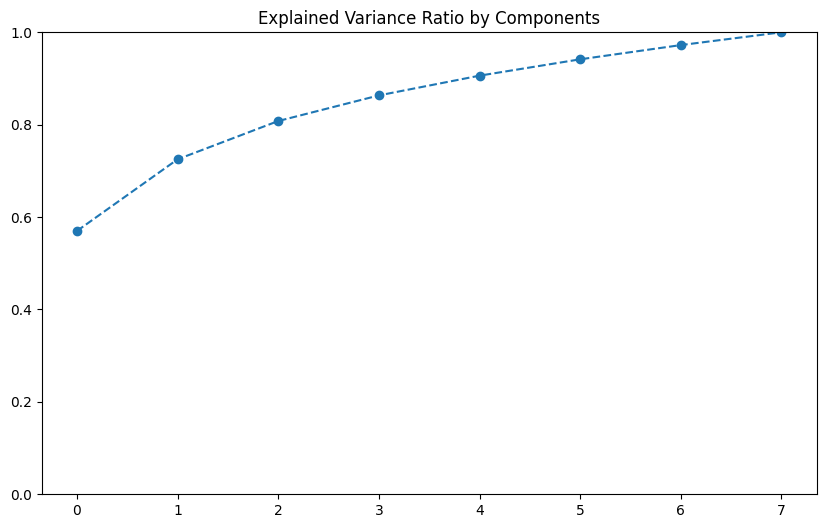

In [19]:
# plot that as scree plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(full_pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')

plt.ylim(0, 1)

plt.title('Explained Variance Ratio by Components')

### Cluster the Full-PCA Data

In [20]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=42)

kmeans.fit(full_pca_data)

KMeans(n_clusters=10, random_state=42)

In [21]:
df_pca = pd.DataFrame(full_pca_data, columns=[f'PC{i+1}' for i in range(8)])
df_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,-2.146662,6.309873,2.847497,1.661612,-0.380966,0.558866,3.224627,-2.244280
1,-10.241980,1.994771,1.094471,-0.056839,1.128737,-0.520707,0.166239,0.112915
2,-4.280307,3.930911,2.313857,1.493830,-0.472542,-1.017856,-0.681361,0.126458
3,-8.189816,0.824535,-0.377890,-2.807615,-5.150495,0.289322,1.946568,-0.694300
4,-8.279460,-0.192799,0.494286,0.437024,0.278552,-0.315461,-1.306297,0.032515
...,...,...,...,...,...,...,...,...
38015995,0.355609,0.656815,-2.344700,-0.974535,1.516261,-0.688860,1.459510,0.388102
38015996,3.163278,0.248483,-0.595535,1.072890,0.756650,-1.064724,0.149820,0.127025
38015997,-1.936004,-0.448470,0.981843,-0.526158,-0.247081,0.022939,0.703619,-0.558975
38015998,-0.367581,0.719019,0.163409,-1.202186,2.229279,-1.623661,0.801838,1.668966


In [22]:
kmeans.labels_.shape

(38016000,)

In [23]:
print(df_pca.shape)
print(kmeans.labels_.shape)
print(labels.shape)

(38016000, 8)
(38016000,)
torch.Size([38016000])


In [24]:
df_pca = df_pca.reset_index(drop=True)

df_pca['Cluster'] = kmeans.labels_
df_pca['Labels'] = labels

In [25]:
df_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,Cluster,Labels
0,-2.146662,6.309873,2.847497,1.661612,-0.380966,0.558866,3.224627,-2.244280,5,1
1,-10.241980,1.994771,1.094471,-0.056839,1.128737,-0.520707,0.166239,0.112915,7,1
2,-4.280307,3.930911,2.313857,1.493830,-0.472542,-1.017856,-0.681361,0.126458,5,1
3,-8.189816,0.824535,-0.377890,-2.807615,-5.150495,0.289322,1.946568,-0.694300,7,1
4,-8.279460,-0.192799,0.494286,0.437024,0.278552,-0.315461,-1.306297,0.032515,7,1
...,...,...,...,...,...,...,...,...,...,...
38015995,0.355609,0.656815,-2.344700,-0.974535,1.516261,-0.688860,1.459510,0.388102,9,0
38015996,3.163278,0.248483,-0.595535,1.072890,0.756650,-1.064724,0.149820,0.127025,0,0
38015997,-1.936004,-0.448470,0.981843,-0.526158,-0.247081,0.022939,0.703619,-0.558975,5,0
38015998,-0.367581,0.719019,0.163409,-1.202186,2.229279,-1.623661,0.801838,1.668966,9,0


## Calculate Cluster Purity for 10 Clusters

In [30]:
type(df_pca)

dask_expr._collection.DataFrame

In [31]:
import dask.dataframe as dd
import pandas as pd

# Assuming df_pca is originally a pandas DataFrame
# Convert to Dask DataFrame with an appropriate number of partitions
if type(df_pca) == pd.DataFrame:
    df_pca = dd.from_pandas(df_pca, npartitions=4)  # Adjust 'npartitions' as needed

# Convert columns to categorical for memory efficiency
df_pca['Cluster'] = df_pca['Cluster'].astype('category')
df_pca['Labels'] = df_pca['Labels'].astype('category')

# Persist the DataFrame (cache in memory)
df_pca = df_pca.persist()

# Proceed with further analysis, such as calculating purity
# Example: Calculate purity ratios per cluster

# 1. Group by 'Cluster' and 'Labels' and count using Dask
counts = df_pca.groupby(['Cluster', 'Labels']).size()

# 2. Trigger computation to get a pandas Series
counts_pd = counts.compute()

# 3. Use pandas to unstack the multi-index Series into a DataFrame
cluster_label_counts = counts_pd.unstack(fill_value=0)

# 4. Calculate ratios
cluster_label_ratio = cluster_label_counts.div(cluster_label_counts.sum(axis=1), axis=0)

# 5. Rename columns for clarity
cluster_label_counts.columns = ['Count_Label_0', 'Count_Label_1']
cluster_label_ratio.columns = ['Ratio_Label_0', 'Ratio_Label_1']

# 6. Combine counts and ratios
purity_df = pd.concat([cluster_label_counts, cluster_label_ratio], axis=1).reset_index()

# 7. Display the results
print(purity_df)

/Users/ariellubonja/prog/DiffTumor/venv/lib/python3.11/site-packages/dask_expr/_groupby.py:1548: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  self._meta = self.obj._meta.groupby(


  Cluster  Count_Label_0  Count_Label_1  Ratio_Label_0  Ratio_Label_1
0       0        5216144         906419       0.851954       0.148046
1       1         437339           4048       0.990829       0.009171
2       2        1718668         387644       0.815961       0.184039
3       3        1892482         413695       0.820614       0.179386
4       4         906615         247209       0.785748       0.214252
5       5        6025025        2114700       0.740200       0.259800
6       6         329932         149307       0.688450       0.311550
7       7        1429263         247951       0.852165       0.147835
8       8         390600          15978       0.960701       0.039299
9       9       12757932        2425049       0.840278       0.159722


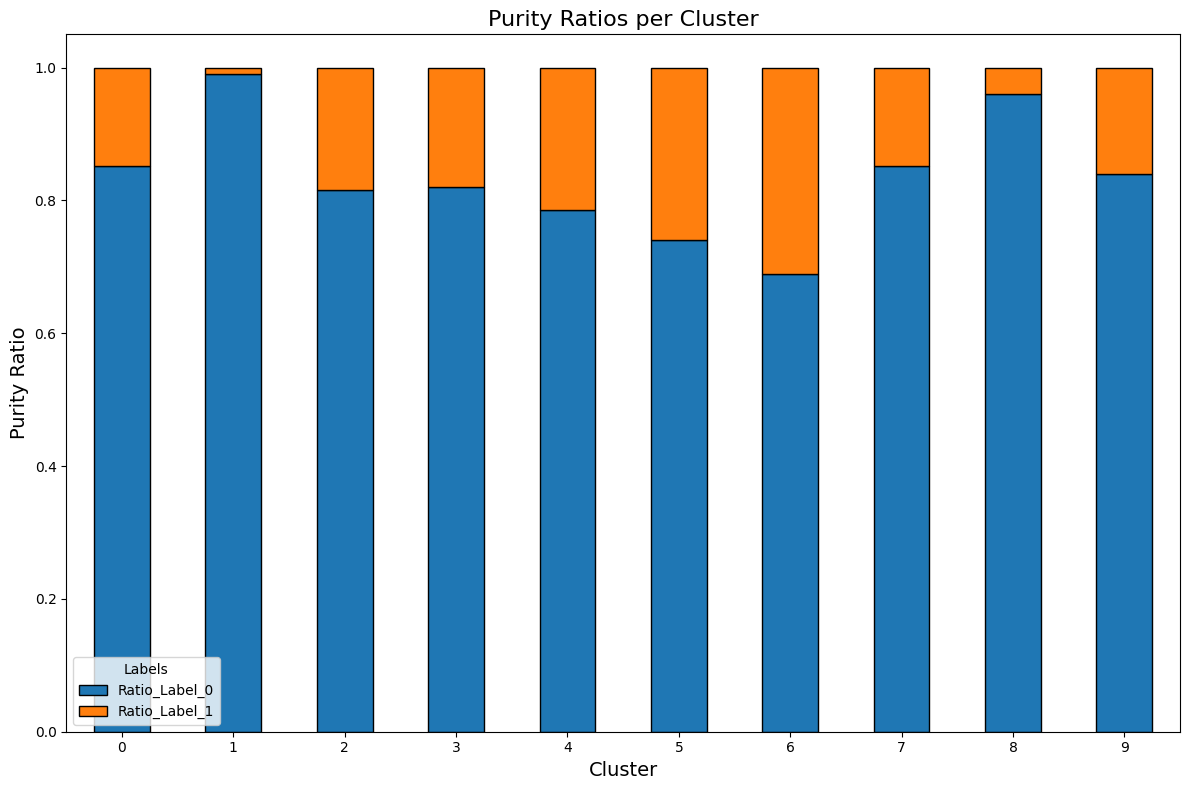

In [32]:
import matplotlib.pyplot as plt
import pandas as pd

# Sample DataFrame (replace this with your actual purity_df)
# purity_df = pd.read_csv('purity_df.csv')  # if reading from a CSV

# Set 'Cluster' as the index for easier plotting
purity_df.set_index('Cluster', inplace=True)

# Plotting the stacked bar chart
ax = purity_df[['Ratio_Label_0', 'Ratio_Label_1']].plot(
    kind='bar',
    stacked=True,
    figsize=(12, 8),
    color=['#1f77b4', '#ff7f0e'],
    edgecolor='black'
)

# Adding labels and title
ax.set_xlabel('Cluster', fontsize=14)
ax.set_ylabel('Purity Ratio', fontsize=14)
ax.set_title('Purity Ratios per Cluster', fontsize=16)
ax.legend(title='Labels')

# Displaying the plot
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
count_zeros = (labels == 0).sum().item()
count_ones = (labels == 1).sum().item()

print(count_zeros, count_ones)

print(count_zeros / len(labels), count_ones / len(labels))

31104000 6912000
0.8181818181818182 0.18181818181818182


## Try for Multiple # clusters, hyperparameters

#### Function Definitions 📚

In [18]:
import pandas as pd
import dask.dataframe as dd
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import matplotlib.pyplot as plt


def calculate_purities(data, labels, algorithms, plot=True):
    """
    Calculate purity ratios for multiple clustering algorithms.

    Parameters:
    - data: array-like, shape (n_samples, n_features)
        The data to cluster.
    - labels: array-like, shape (n_samples,)
        The true labels.
    - algorithms: list of tuples (name, estimator)
        Each tuple contains a unique name for the algorithm and an instance of a clustering estimator.
    - plot: bool, default=True
        Whether to plot purity ratios.

    Returns:
    - pd.DataFrame: A DataFrame containing purity counts and ratios per cluster for each algorithm.
    """
    results = []

    for name, estimator in algorithms:
        # Fit the clustering algorithm
        estimator.fit(data)
        
        # Obtain cluster labels
        if hasattr(estimator, 'labels_'):
            cluster_labels = estimator.labels_
        elif hasattr(estimator, 'predict'):
            cluster_labels = estimator.predict(data)
        else:
            raise AttributeError(f"The estimator {name} does not have 'labels_' or 'predict' method.")

        # Create DataFrame with data, cluster labels, and true labels
        df = pd.DataFrame(data, columns=[f'Feature_{i+1}' for i in range(data.shape[1])])
        df = df.reset_index(drop=True)
        df['Cluster'] = cluster_labels
        df['Labels'] = labels

        # Convert to Dask DataFrame
        if isinstance(df, pd.DataFrame):
            df_dd = dd.from_pandas(df, npartitions=4)  # Fixed number of partitions
        else:
            df_dd = df  # Assume already a Dask DataFrame

        # Convert columns to categorical for memory efficiency
        df_dd['Cluster'] = df_dd['Cluster'].astype('category')
        df_dd['Labels'] = df_dd['Labels'].astype('category')

        # Persist the DataFrame (cache in memory)
        df_dd = df_dd.persist()

        # Group by 'Cluster' and 'Labels' and count
        counts = df_dd.groupby(['Cluster', 'Labels']).size()
        
        # Trigger computation to get a pandas Series
        counts_pd = counts.compute()
        
        # Unstack the multi-index Series into a DataFrame
        cluster_label_counts = counts_pd.unstack(fill_value=0)
        
        # Calculate ratios
        cluster_label_ratio = cluster_label_counts.div(cluster_label_counts.sum(axis=1), axis=0)
        
        # Rename columns for clarity
        cluster_label_counts.columns = [f'Count_Label_{col}' for col in cluster_label_counts.columns]
        cluster_label_ratio.columns = [f'Ratio_Label_{col}' for col in cluster_label_ratio.columns]
        
        # Combine counts and ratios
        purity_df = pd.concat([cluster_label_counts, cluster_label_ratio], axis=1).reset_index()
        purity_df['Algorithm'] = name

        # Optionally, extract n_clusters if available
        if hasattr(estimator, 'n_clusters'):
            purity_df['n_clusters'] = estimator.n_clusters
        else:
            purity_df['n_clusters'] = None

        # Append to results
        results.append(purity_df)

    # Concatenate all results into a single DataFrame
    final_df = pd.concat(results, ignore_index=True)

    # Optional Plotting
    if plot:
        for algo in final_df['Algorithm'].unique():
            algo_df = final_df[final_df['Algorithm'] == algo].copy()
            algo_df.set_index('Cluster', inplace=True)
            
            # Identify ratio columns
            ratio_cols = [col for col in algo_df.columns if col.startswith('Ratio_Label_')]
            
            # Plotting the stacked bar chart
            ax = algo_df[ratio_cols].plot(
                kind='bar',
                stacked=True,
                figsize=(12, 8),
                edgecolor='black',
                title=f'Purity Ratios per Cluster for {algo}'
            )
            
            # Adding labels and title
            ax.set_xlabel('Cluster', fontsize=14)
            ax.set_ylabel('Purity Ratio', fontsize=14)
            ax.legend(title='Labels')
            
            # Displaying the plot
            plt.xticks(rotation=0)
            plt.tight_layout()
            plt.show()
            
            # Reset index for potential further use
            algo_df.reset_index(inplace=True)

    return final_df

#### Evaluation

In [ ]:
# Define clustering algorithms with different hyperparameters
algorithms = [
    ('KMeans_n3', KMeans(n_clusters=3, random_state=42)),
    ('KMeans_n4', KMeans(n_clusters=4, random_state=42)),
    ('Agglomerative_n3', AgglomerativeClustering(n_clusters=3)),
    ('Agglomerative_n4', AgglomerativeClustering(n_clusters=4)),
    ('DBSCAN_eps0.5', DBSCAN(eps=0.5)),
    ('DBSCAN_eps0.7', DBSCAN(eps=0.7)),
    # Add more algorithms and hyperparameters as needed
]

# Calculate purities
purity_results = calculate_purities(
    data=full_pca_data,
    labels=labels,
    algorithms=algorithms,
    plot=True  # Set to False if you don't want plots
)

# Display the results
purity_results

## Plot First 2 and 3 Components

## Plotting 10 clusters on the PCA-ed features

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
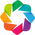

BokehModel(combine_events=True, render_bundle={'docs_json': {'266d2c69-9736-4e29-abde-85e0eb27df9c': {'version…

In [36]:
import holoviews as hv
from holoviews.operation.datashader import datashade
import datashader as ds
from bokeh.palettes import Category10, Category20, viridis
hv.extension('bokeh')

# Define color palette based on the number of unique clusters
unique_clusters = sorted(df_pca['Cluster'].unique())
num_clusters = len(unique_clusters)

if num_clusters <= 10:
    palette = Category10[10]
elif num_clusters <= 20:
    palette = Category20[20]
else:
    palette = viridis(num_clusters)

# Create a categorical color map
color_key = {str(cluster): palette[i % len(palette)] for i, cluster in enumerate(unique_clusters)}

# Create HoloViews Points element with 'Cluster' as a categorical dimension
points = hv.Points(df_pca, ['PC1', 'PC2'], 'Cluster')

# Apply Datashader with the defined color map and appropriate aggregator
shaded = datashade(
    points, 
    cmap=palette, 
    aggregator=ds.count_cat('Cluster'),  # Aggregate counts per cluster
).opts(
    width=800,
    height=600,
    title='KMeans Clusters on First Two Principal Components'
)

# Display the plot
shaded

##### <font color='orange'> This is gonna take forever</font>

Datashader doesn't support 3D plots. This means very slow projection

In [ ]:
import plotly.express as px
import pandas as pd
import numpy as np

# Sample Data Generation (Replace this with your actual df_pca DataFrame)
np.random.seed(42)
num_points = 1000  # Adjust based on your dataset size
df_pca = pd.DataFrame({
    'PC1': np.random.randn(num_points),
    'PC2': np.random.randn(num_points),
    'PC3': np.random.randn(num_points),
    'Cluster': np.random.randint(0, 10, size=num_points)  # Example with 10 clusters
})

# Create a 3D Scatter Plot using Plotly Express
fig = px.scatter_3d(
    df_pca,
    x='PC1',
    y='PC2',
    z='PC3',
    color='Cluster',
    title='KMeans Clusters on First Three Principal Components',
    hover_data=df_pca.columns[:-1],
    color_continuous_scale='Viridis'  # Choose a color scale or use discrete colors
)

# Update layout for better visualization (optional)
fig.update_layout(
    width=800,
    height=600,
    legend_title='Cluster',
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    )
)

# Display the 3D plot
fig.show()

## Plotting all (38M, 8) vectors

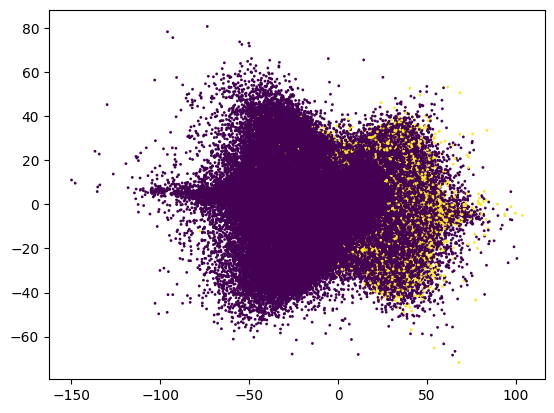

In [ ]:
# Results for PCA on (50, 55, 8, 24, 24, 24), 8

from matplotlib import pyplot as plt

plt.scatter(pca_results[:, 0], pca_results[:, 1], c=labels, cmap='viridis', s=1)

# Plotting

In [ ]:

pca_solver_2d = PCA(n_components=2, random_state=42)

pca_results = pca_solver_2d.fit_transform(flattened_features)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
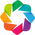

In [33]:
import holoviews as hv
hv.extension('bokeh')  # Initialize HoloViews with the Bokeh backend

In [34]:
import holoviews as hv
import datashader as ds
from holoviews.operation.datashader import datashade
from sklearn.decomposition import PCA
import pandas as pd
from bokeh.palettes import Category10, Category20


# Create a DataFrame
df = pd.DataFrame(pca_results, columns=['PC1', 'PC2'])

df['Label'] = labels.numpy().astype(str)  # Convert labels to string for categorical coloring

# Define color palette
unique_labels = df['Label'].unique()
num_labels = len(unique_labels)
palette = Category10[10] if num_labels <= 10 else Category20[20]

# Create a color key mapping each label to a color
color_key = {label: palette[i % len(palette)] for i, label in enumerate(unique_labels)}

# Create HoloViews Points with 'Label' as a categorical dimension
points = hv.Points(df, ['PC1', 'PC2'], ['Label'])

# Apply Datashader with the color_key
shaded = datashade(points, cmap=color_key, how='log', aggregator=ds.count_cat('Label')).opts(
    width=800,  # Set the width
    height=600  # Set the height
)

# Display the shaded plot
shaded

:DynamicMap   []
   :RGB   [PC1,PC2]   (R,G,B,A)

In [35]:
from sklearn.decomposition import PCA

pca_solver_3d = PCA(n_components=3, random_state=42)

pca_results_3d = pca_solver_3d.fit_transform(flattened_features)

In [36]:
import holoviews as hv
import pandas as pd
import numpy as np
import plotly.io as pio

# Initialize HoloViews with the Plotly backend
hv.extension('plotly')

# Assuming you have 3 PCA components and labels
# Generate some random PCA data for illustration
pca_results = np.random.rand(1000, 3)  # Replace with your actual PCA results
labels = np.random.randint(0, 5, size=1000)  # Replace with your actual labels

# Create a DataFrame with PCA results and labels
df = pd.DataFrame(pca_results, columns=['PC1', 'PC2', 'PC3'])
df['Label'] = labels.astype(str)  # Convert labels to string for categorical coloring

# Create a 3D scatter plot using HoloViews and Plotly
scatter = hv.Scatter3D(df, kdims=['PC1', 'PC2', 'PC3'], vdims='Label').opts(
    color='Label',  # Color based on Label
    cmap='Category10',  # Choose a colormap for the labels
    size=5,  # Set marker size
    width=800,  # Set width of the plot
    height=600,  # Set height of the plot
    marker='circle',  # Set marker type
    title="3D PCA Scatter Plot"  # Add a title
)

# Display the 3D plot
scatter

ModuleNotFoundError: No module named 'plotly'

## Setup

In [15]:
patient_ids = healthy_patient_ids + panc_patient_ids
labels = labels.tolist()

In [16]:
patient_ids

['BDMAP_00000002',
 'BDMAP_00000110',
 'BDMAP_00000198',
 'BDMAP_00000246',
 'BDMAP_00000351',
 'BDMAP_00000598',
 'BDMAP_00000673',
 'BDMAP_00000682',
 'BDMAP_00000764',
 'BDMAP_00000846',
 'BDMAP_00000878',
 'BDMAP_00000928',
 'BDMAP_00001002',
 'BDMAP_00001348',
 'BDMAP_00001662',
 'BDMAP_00001774',
 'BDMAP_00001820',
 'BDMAP_00001871',
 'BDMAP_00001942',
 'BDMAP_00001943',
 'BDMAP_00002059',
 'BDMAP_00002212',
 'BDMAP_00002236',
 'BDMAP_00002569',
 'BDMAP_00002650',
 'BDMAP_00002753',
 'BDMAP_00002763',
 'BDMAP_00003013',
 'BDMAP_00003033',
 'BDMAP_00003085',
 'BDMAP_00003154',
 'BDMAP_00003265',
 'BDMAP_00003577',
 'BDMAP_00003644',
 'BDMAP_00003876',
 'BDMAP_00004098',
 'BDMAP_00004142',
 'BDMAP_00004202',
 'BDMAP_00004360',
 'BDMAP_00004458',
 'BDMAP_00004480',
 'BDMAP_00005110',
 'BDMAP_00000416',
 'BDMAP_00000541',
 'BDMAP_00001646',
 'BDMAP_00001754',
 'BDMAP_00002402',
 'BDMAP_00003326',
 'BDMAP_00003427',
 'BDMAP_00004229',
 'BDMAP_00004231',
 'BDMAP_00004847',
 'BDMAP_0000

In [17]:
labels

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

### Plotting Code (Long)

In [18]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib import colormaps  # Import the correct module for colormaps

# Function to plot 2D scatter plot with annotations and cluster centroids with variance ellipses
def plot_2d(features_high_dim, labels, patient_ids, clusters, title):
    """
    Plots a 2D PCA scatter plot with data points colored by ground truth labels and cluster centroids.

    Parameters:
    - features_high_dim: NumPy array of shape (n_samples, n_features), original high-dimensional data.
    - labels: List or array of ground truth labels.
    - patient_ids: List of patient ID strings.
    - clusters: NumPy array of cluster assignments.
    - title: Title of the plot.
    """
    # Perform PCA to reduce to 2D
    features_2d = features_high_dim
    if features_high_dim.shape[1] > 2:
        pca_2d = PCA(n_components=2)
        features_2d = pca_2d.fit_transform(features_high_dim)
    
    plt.figure(figsize=(12, 8))
    
    # Define colors for labels
    label_colors = {0: 'blue', 1: 'red'}
    colors = [label_colors[label] for label in labels]
    
    # Plot data points
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=colors, s=50, alpha=0.7)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')

    # Add annotations for patient IDs
    # for i, patient_id in enumerate(patient_ids):
    #     plt.annotate(patient_id, (features_2d[i, 0], features_2d[i, 1]), fontsize=8, alpha=0.6)

    # Compute and plot centroids and variance ellipses
    unique_clusters = np.unique(clusters)
    cmap = colormaps.get_cmap('tab10')  # Use the new colormap API without the 'lut' parameter

    for i, cluster in enumerate(unique_clusters):
        cluster_points = features_2d[clusters == cluster]
        if cluster_points.shape[0] == 0:
            continue  # Skip empty clusters
        centroid = cluster_points.mean(axis=0)
        covariance = np.cov(cluster_points, rowvar=False)
        
        if covariance.shape == (2, 2):
            eigenvalues, eigenvectors = np.linalg.eigh(covariance)
            
            # Sort eigenvalues and eigenvectors
            order = eigenvalues.argsort()[::-1]
            eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
            
            # Compute angle for the ellipse
            angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
            
            # Width and height are "full" widths, so we multiply by 2 to get full length
            width, height = 2 * np.sqrt(eigenvalues)
            
            # Create and add the ellipse patch
            ellipse = Ellipse(xy=centroid, width=width, height=height, angle=angle,
                              edgecolor=cmap(i), facecolor='none', linewidth=2)
            plt.gca().add_patch(ellipse)
        
        # Plot centroid
        plt.scatter(centroid[0], centroid[1], marker='X', s=200, c=[cmap(i)], label=f'Centroid {cluster}')

    # Create legend for labels
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                          markerfacecolor=color, markersize=10) for label, color in label_colors.items()]
    
    # Create legend for centroids
    centroid_handles = [plt.Line2D([0], [0], marker='X', color='w', label=f'Centroid {cluster}',
                                   markerfacecolor=cmap(i), markersize=10) for i, cluster in enumerate(unique_clusters)]
    
    # Combine both legends
    plt.legend(handles=handles + centroid_handles, loc='best')
    plt.grid(True)
    plt.show()

# Function to plot 3D scatter plot with annotations and cluster centroids
def plot_3d(features_high_dim, labels, patient_ids, clusters, title):
    """
    Plots a 3D PCA scatter plot with data points colored by ground truth labels and cluster centroids.

    Parameters:
    - features_high_dim: NumPy array of shape (n_samples, n_features), original high-dimensional data.
    - labels: List or array of ground truth labels.
    - patient_ids: List of patient ID strings.
    - clusters: NumPy array of cluster assignments.
    - title: Title of the plot.
    """
    # Perform PCA to reduce to 3D
    features_3d = features_high_dim
    if features_high_dim.shape[1] > 3:
        pca_3d = PCA(n_components=3)
        features_3d = pca_3d.fit_transform(features_high_dim)
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Define colors for labels
    label_colors = {0: 'blue', 1: 'red'}
    colors = [label_colors[label] for label in labels]
    
    # Plot data points
    scatter = ax.scatter(features_3d[:, 0], features_3d[:, 1], features_3d[:, 2],
                         c=colors, s=50, alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')

    # Add annotations for patient IDs
    # Annotations in 3D are more cluttered, so we skip them for now
    # for i, patient_id in enumerate(patient_ids):
        # ax.text(features_3d[i, 0], features_3d[i, 1], features_3d[i, 2], patient_id, size=8, alpha=0.6)
    
    # Compute and plot centroids
    unique_clusters = np.unique(clusters)
    cmap = colormaps.get_cmap('tab10')  # Use the new colormap API without the 'lut' parameter

    for i, cluster in enumerate(unique_clusters):
        cluster_points = features_3d[clusters == cluster]
        if cluster_points.shape[0] == 0:
            continue  # Skip empty clusters
        centroid = cluster_points.mean(axis=0)
        # Plot centroid
        ax.scatter(centroid[0], centroid[1], centroid[2], marker='X', s=200, c=[cmap(i)], label=f'Centroid {cluster}')

    # Create legend for labels
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                          markerfacecolor=color, markersize=10) for label, color in label_colors.items()]
    
    # Create legend for centroids
    centroid_handles = [plt.Line2D([0], [0], marker='X', color='w', label=f'Centroid {cluster}',
                                   markerfacecolor=cmap(i), markersize=10) for i, cluster in enumerate(unique_clusters)]
    
    # Combine both legends
    ax.legend(handles=handles + centroid_handles, loc='best')
    plt.show()


import plotly.graph_objects as go
from sklearn.decomposition import PCA
import numpy as np
import plotly

import plotly.graph_objs as go
import plotly
from sklearn.decomposition import PCA
import numpy as np

def plot_3d_interactive(features_high_dim, labels, patient_ids, clusters, title, plot_axes=False):
    """
    Creates an interactive 3D PCA scatter plot using Plotly with data points colored by ground truth labels and cluster centroids.

    Parameters:
    - features_high_dim: NumPy array of shape (n_samples, n_features), original high-dimensional data.
    - labels: List or array of ground truth labels.
    - patient_ids: List of patient ID strings.
    - clusters: NumPy array of cluster assignments.
    - title: Title of the plot.
    """
    # Perform PCA to reduce to 3D
    features_3d = features_high_dim
    if features_high_dim.shape[1] > 3:
        pca_3d = PCA(n_components=3)
        features_3d = pca_3d.fit_transform(features_high_dim)
    
    # Define colors for labels
    label_colors = {0: 'blue', 1: 'red'}
    colors = [label_colors[label] for label in labels]

    # Create a Plotly scatter plot for the data points
    scatter = go.Scatter3d(
        x=features_3d[:, 0],
        y=features_3d[:, 1],
        z=features_3d[:, 2],
        mode='markers',  # Changed from 'markers+text' to 'markers'
        marker=dict(
            size=5,
            color=colors,  # Use label colors for data points
            opacity=0.8
        ),
        text=patient_ids,  # Patient IDs for hover
        hovertemplate='<b>%{text}</b><br>Cluster: %{marker.color}<extra></extra>'
    )

    # Compute centroids
    unique_clusters = np.unique(clusters)
    cluster_colors = plotly.colors.qualitative.T10  # Use a qualitative colormap for centroids

    # List to hold centroid traces
    centroid_traces = []

    for i, cluster in enumerate(unique_clusters):
        cluster_points = features_3d[clusters == cluster]
        if cluster_points.shape[0] == 0:
            continue  # Skip empty clusters
        centroid = cluster_points.mean(axis=0)

        # Create a scatter plot for each centroid
        centroid_trace = go.Scatter3d(
            x=[centroid[0]],
            y=[centroid[1]],
            z=[centroid[2]],
            mode='markers',
            marker=dict(
                size=5,
                color=cluster_colors[i % len(cluster_colors)],  # Cycle through colors
                symbol='x',
                opacity=0.5
            ),
            name=f'Centroid {cluster}'
        )
        centroid_traces.append(centroid_trace)

    # Create the layout for the Plotly figure
    layout = go.Layout(
        title=title,
        scene=dict(
            xaxis=dict(visible=plot_axes),  # Hide X-axis
            yaxis=dict(visible=plot_axes),  # Hide Y-axis
            zaxis=dict(visible=plot_axes),  # Hide Z-axis
        ),
        showlegend=False
    )

    # Combine scatter and centroid traces
    fig = go.Figure(data=[scatter] + centroid_traces, layout=layout)
    fig.show()

## Best PCA

First, perform best clustering - need to find optimal hyperparameters above

<font color='cyan'>From Excel spreadsheet, best choice was: PCA - 36 components - 6 clusters AND T-SNE: 7 clusters, learning_rate	n_components	n_iter	perplexity 10	42	1000	50</font>

In [19]:
from sklearn.decomposition import PCA

best_PCA = PCA(n_components=36, random_state=42)

best_pca_features = best_PCA.fit_transform(flattened_features_std)

In [20]:
from sklearn.cluster import KMeans

best_pca_clustering = KMeans(n_clusters=7, random_state=42)

In [21]:
best_pca_clusters = best_pca_clustering.fit_predict(best_pca_features)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [34]:
best_pca_features.shape

(55, 36)

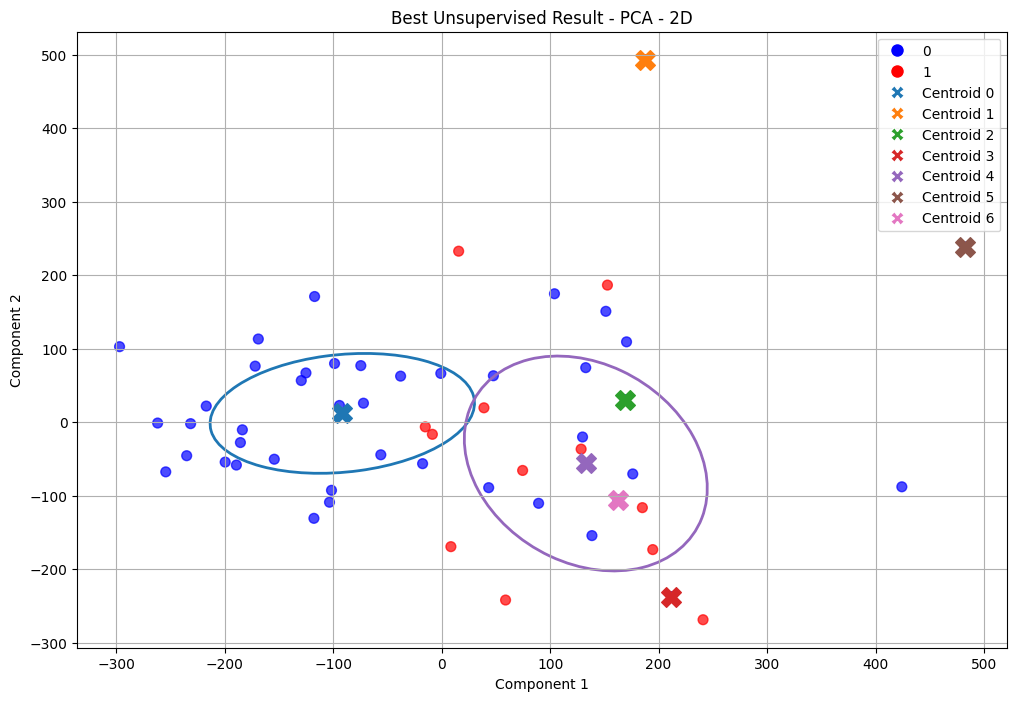

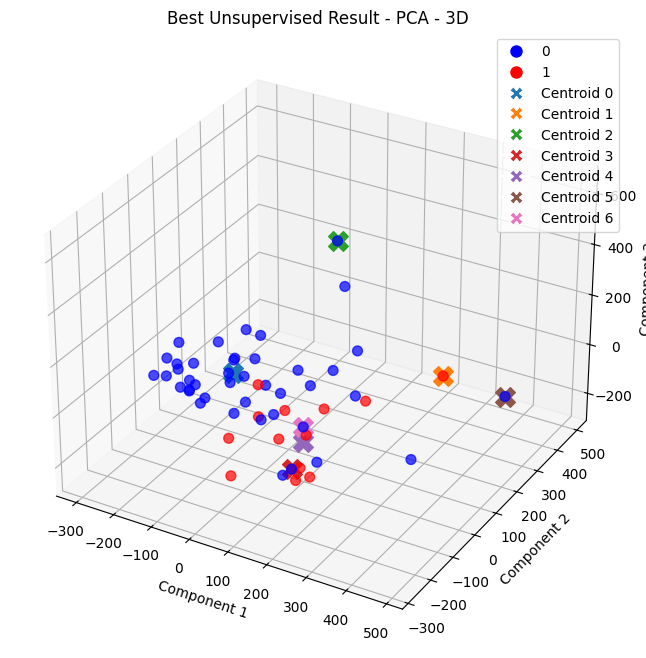

In [22]:
# --- Plotting the Results ---

# Plot the best unsupervised result in 2D
plot_2d(best_pca_features, labels, patient_ids, best_pca_clusters, f'Best Unsupervised Result - PCA - 2D')

# Plot the best unsupervised result in 3D
plot_3d(best_pca_features, labels, patient_ids, best_pca_clusters, f'Best Unsupervised Result - PCA - 3D')

In [23]:
plot_3d_interactive(
    features_high_dim=best_pca_features,
    labels=labels,
    patient_ids=patient_ids,
    clusters=best_pca_clusters,
    title='Best Unsupervised Result - PCA - 3D (Interactive)'
)

## Best T-SNE

In [24]:
from sklearn.manifold import TSNE

best_tsne = TSNE(n_components=42, perplexity=50, learning_rate=10, n_iter=1000, random_state=42, method='exact')

best_tsne_features = best_tsne.fit_transform(flattened_features_std)

In [25]:
best_tsne_clustering = KMeans(n_clusters=7, random_state=42)

best_tsne_clusters = best_tsne_clustering.fit_predict(best_tsne_features)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



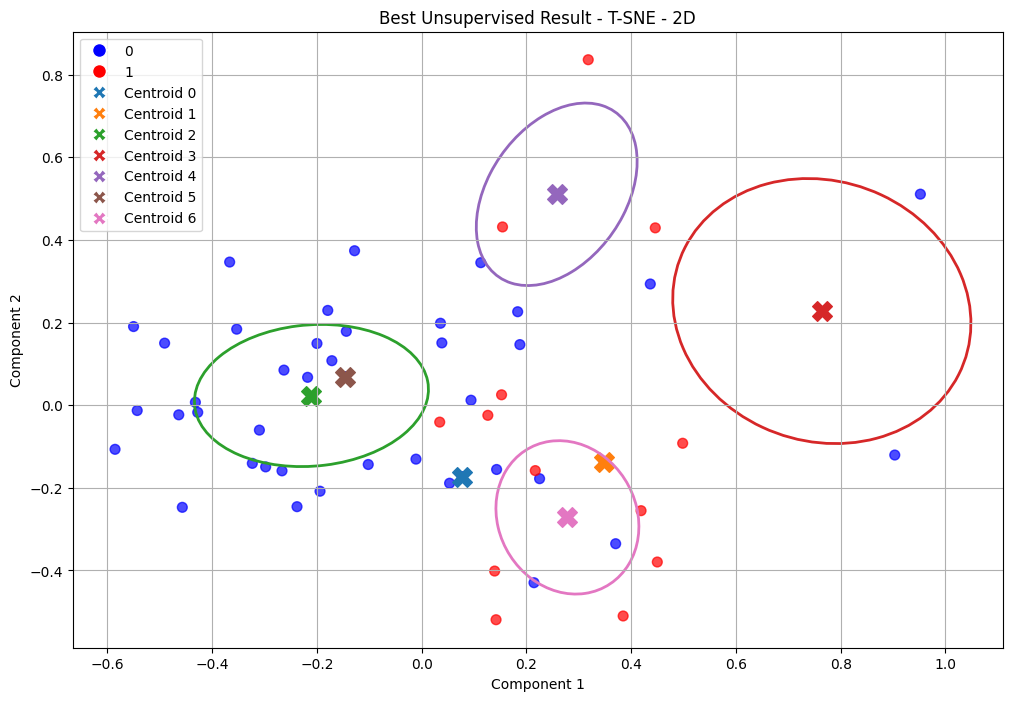

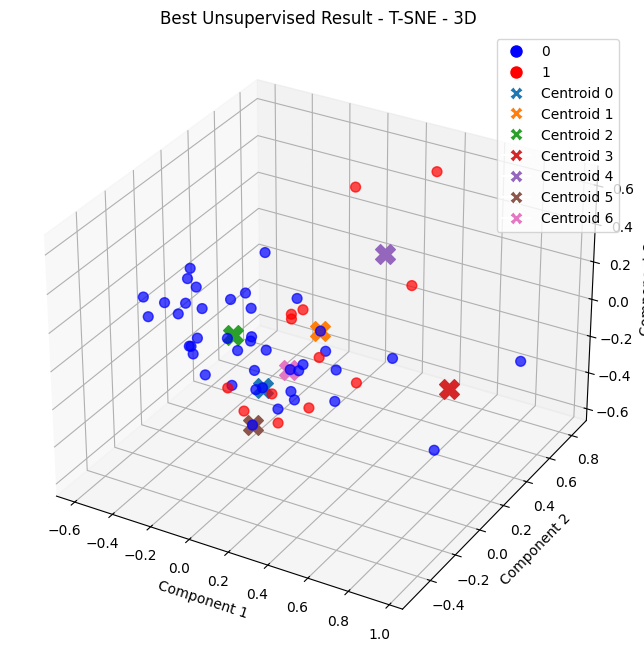

In [26]:
plot_2d(best_tsne_features, labels, patient_ids, best_tsne_clusters, f'Best Unsupervised Result - T-SNE - 2D')

# Plot the best unsupervised result in 3D
plot_3d(best_tsne_features, labels, patient_ids, best_tsne_clusters, f'Best Unsupervised Result - T-SNE - 3D')

In [27]:
plot_3d_interactive(
    features_high_dim=best_tsne_features,
    labels=labels,
    patient_ids=patient_ids,
    clusters=best_tsne_clusters,
    title='Best Unsupervised Result - T-SNE - 3D (Interactive)',
    plot_axes=True
)

Outlier 5070

![5070.png](mkdown-imgs/5070.png)


Outlier 3427

![3427.png](mkdown-imgs/3427.png)


Outlier 928 - I think this CT is just Shifted from the rest, so it appears as an outlier



![928.png](mkdown-imgs/928.png)

## T-SNE w/ only 2,3 components (Worse)

In [28]:
best_2d_tsne = TSNE(n_components=2, perplexity=40, learning_rate=10, n_iter=1000, random_state=42, method='exact')
best_2d_tsne_clusterer = KMeans(n_clusters=2, random_state=42)

best_3d_tsne = TSNE(n_components=3, perplexity=50, learning_rate=10, n_iter=1000, random_state=42, method='exact')
best_3d_tsne_clusterer = KMeans(n_clusters=2, random_state=42)

In [29]:
best_2d_tsne_features = best_2d_tsne.fit_transform(flattened_features_std)
best_3d_tsne_features = best_3d_tsne.fit_transform(flattened_features_std)

best_2d_tsne_clusters = best_2d_tsne_clusterer.fit_predict(best_2d_tsne_features)
best_3d_tsne_clusters = best_3d_tsne_clusterer.fit_predict(best_3d_tsne_features)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



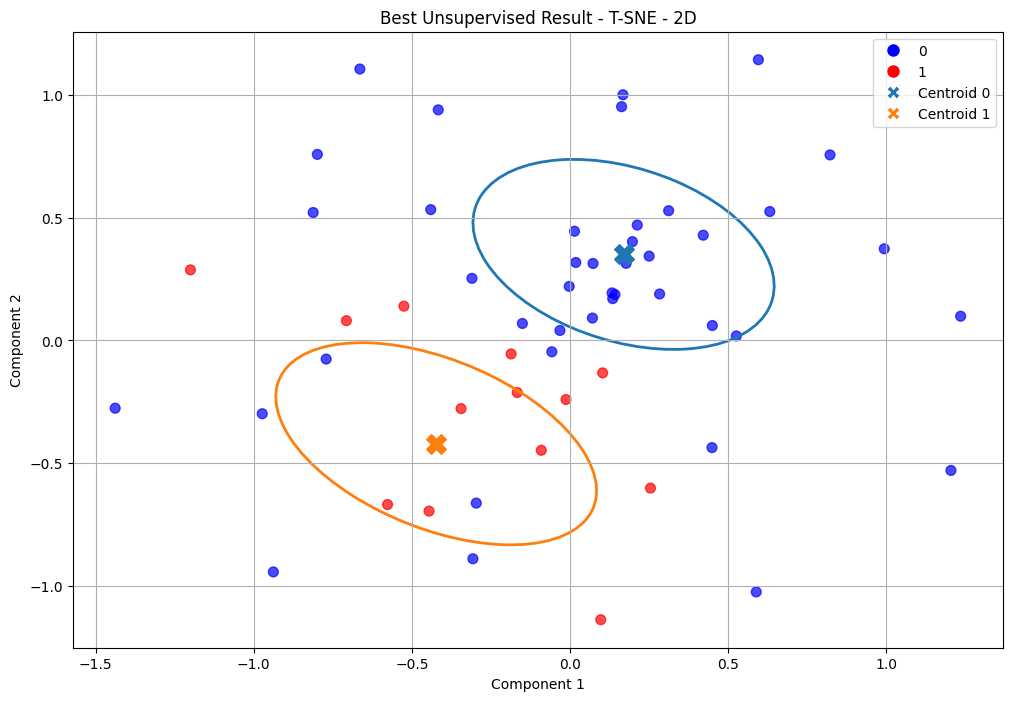

In [30]:
plot_2d(best_2d_tsne_features, labels, patient_ids, best_2d_tsne_clusters, f'Best Unsupervised Result - T-SNE - 2D')

In [31]:
best_3d_tsne_features.shape

(55, 3)

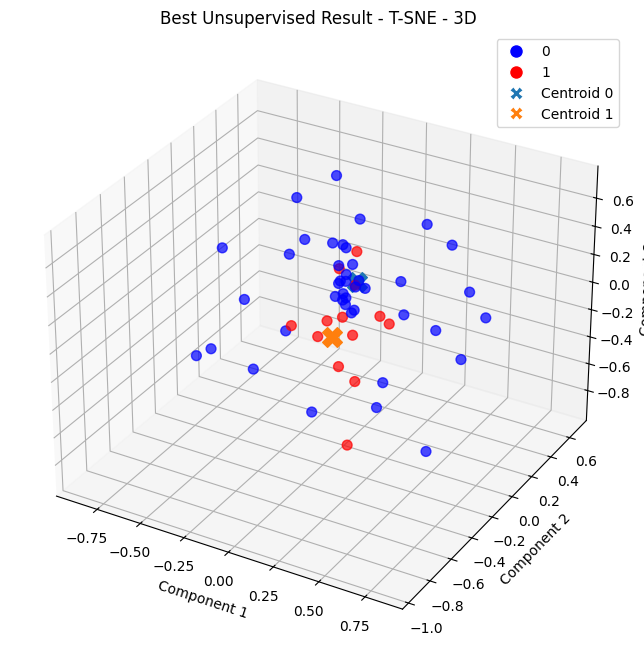

In [32]:
plot_3d(best_3d_tsne_features, labels, patient_ids, best_3d_tsne_clusters, f'Best Unsupervised Result - T-SNE - 3D')

In [33]:
plot_3d_interactive(
    features_high_dim=best_3d_tsne_features,
    labels=labels,
    patient_ids=patient_ids,
    clusters=best_3d_tsne_clusters,
    title='Best Unsupervised Result - T-SNE - 3D (Interactive)')

    

# Logistics - Saving to File

#### Saving to TSV for projector.tensorflow.org

In [76]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap
from sklearn.cluster import KMeans

cluster_assignments = best_pca_clusters

def save_to_projector_tensorflow_tsv(embedding, cluster_assignments, labels, save_name=""):
    # Prepare data for TSV files
    # Create a DataFrame for the embedding
    embedding_df = pd.DataFrame(embedding)

    # Add cluster assignments and true labels
    embedding_df['Cluster'] = cluster_assignments
    embedding_df['Label'] = labels  # Ensure 'labels' is an array-like object

    feature_save_name = os.path.join("tsv_projections", f'features_{save_name}.tsv')
    metadata_save_name = os.path.join("tsv_projections", f'metadata_{save_name}.tsv')

    # Save the embedding vectors (without Cluster and Label columns)
    embedding_df.drop(columns=['Cluster', 'Label']).to_csv(feature_save_name, sep='\t', index=False, header=False)
    print(f"Embedding vectors saved to {feature_save_name}")

    # Save the metadata (Cluster assignments and Labels)
    metadata_df = embedding_df[['Cluster', 'Label']]
    metadata_df.to_csv(metadata_save_name, sep='\t', index=False)
    print(f"Metadata saved to {metadata_save_name}")

In [77]:
save_to_projector_tensorflow_tsv(best_pca_features, best_pca_clusters, labels, save_name="best_pca")

Embedding vectors saved to tsv_projections/features_best_pca.tsv
Metadata saved to tsv_projections/metadata_best_pca.tsv


In [78]:
save_to_projector_tensorflow_tsv(best_tsne_features, best_tsne_clusters, labels, save_name="best_tsne")

Embedding vectors saved to tsv_projections/features_best_tsne.tsv
Metadata saved to tsv_projections/metadata_best_tsne.tsv


In [79]:
save_to_projector_tensorflow_tsv(best_2d_tsne_features, best_2d_tsne_clusters, labels, save_name="best_2d_tsne")

Embedding vectors saved to tsv_projections/features_best_2d_tsne.tsv
Metadata saved to tsv_projections/metadata_best_2d_tsne.tsv


In [80]:
save_to_projector_tensorflow_tsv(best_3d_tsne_features, best_3d_tsne_clusters, labels, save_name="best_3d_tsne")

Embedding vectors saved to tsv_projections/features_best_3d_tsne.tsv
Metadata saved to tsv_projections/metadata_best_3d_tsne.tsv


# Supervised Clustering

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.cross_decomposition import PLSRegression
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

In [ ]:
def apply_nca(features, labels, n_components):
    """
    Apply Neighborhood Components Analysis (NCA).

    Parameters:
        features (numpy.ndarray): Input features.
        labels (numpy.ndarray): Class labels.
        n_components (int): Number of dimensions to reduce to.

    Returns:
        numpy.ndarray: Transformed features.
    """
    nca = NeighborhoodComponentsAnalysis(n_components=n_components, random_state=42)
    nca.fit(features, labels)
    return nca.transform(features)


def apply_pls(features, labels, n_components):
    """
    Apply Partial Least Squares (PLS) regression.

    Parameters:
        features (numpy.ndarray): Input features.
        labels (numpy.ndarray): Class labels.
        n_components (int): Number of components to keep.

    Returns:
        numpy.ndarray: Transformed features.
    """
    lb = LabelBinarizer()
    labels_binarized = lb.fit_transform(labels)
    pls = PLSRegression(n_components=n_components)
    pls.fit(features, labels_binarized)
    return pls.transform(features)


def apply_supervised_umap(features, labels, n_components, n_neighbors=15, min_dist=0.1):
    """
    Apply Supervised UMAP.

    Parameters:
        features (numpy.ndarray): Input features.
        labels (numpy.ndarray): Class labels.
        n_components (int): Number of dimensions to reduce to.

    Returns:
        numpy.ndarray: Transformed features.
    """
    reducer = umap.UMAP(
        n_components=n_components,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        random_state=42
    )
    return reducer.fit_transform(features, y=labels)

In [ ]:
def evaluate_supervised_methods(features, labels):
    """
    Evaluate clustering with supervised dimensionality reduction methods.

    Parameters:
        features (numpy.ndarray): Scaled features.
        labels (numpy.ndarray): Class labels.

    Returns:
        dict: Results for each method.
    """
    n_components_list = list(range(2, min(features.shape[1], 56), 5))
    n_clusters_list = list(range(2, 8))
    dim_reduction_methods = ['NCA', 'PLS', 'Supervised UMAP']
    clustering_methods = ['kmeans', 'agglomerative', 'gmm']
    
    results = {}
    
    for method in dim_reduction_methods:
        print(f"\nDimensionality Reduction Method: {method}")
        results[method] = {}
        for n_components in n_components_list:
            print(f"  n_components = {n_components}")
            if method == 'NCA':
                try:
                    transformed_features = apply_nca(features, labels, n_components)
                except Exception as e:
                    print(f"    NCA failed at n_components={n_components}: {e}")
                    continue
            elif method == 'PLS':
                try:
                    transformed_features = apply_pls(features, labels, n_components)
                except Exception as e:
                    print(f"    PLS failed at n_components={n_components}: {e}")
                    continue
            elif method == 'Supervised UMAP':
                transformed_features = apply_supervised_umap(features, labels, n_components)
            
            results_key = f"n_components_{n_components}"
            results[method][results_key] = pd.DataFrame(
                index=n_clusters_list,
                columns=clustering_methods
            )
            
            for n_clusters in n_clusters_list:
                for cluster_method in clustering_methods:
                    evaluation = cluster_and_evaluate(
                        transformed_features,
                        method=cluster_method,
                        n_clusters=n_clusters
                    )
                    # Store Silhouette Score
                    results[method][results_key].loc[n_clusters, cluster_method] = evaluation['Silhouette Score']
        print("  Evaluation complete.")
    return results

In [ ]:
supervised_results = evaluate_supervised_methods(flattened_features_std, labels)


Dimensionality Reduction Method: NCA
  n_components = 2
  n_components = 7
  n_components = 12
  n_components = 17
  n_components = 22
  n_components = 27
  n_components = 32
  n_components = 37
  n_components = 42
  n_components = 47
  n_components = 52
  Evaluation complete.

Dimensionality Reduction Method: PLS
  n_components = 2
  n_components = 7
  n_components = 12
  n_components = 17
  n_components = 22
  n_components = 27
  n_components = 32
  n_components = 37
  n_components = 42
  n_components = 47
  n_components = 52
  Evaluation complete.

Dimensionality Reduction Method: Supervised UMAP
  n_components = 2
  n_components = 7
  n_components = 12
  n_components = 17
  n_components = 22
  n_components = 27
  n_components = 32
  n_components = 37
  n_components = 42
  n_components = 47
  n_components = 52
  Evaluation complete.


In [ ]:
for method, n_components_dict in supervised_results.items():
    print(f"\nResults for {method}:\n")
    for n_components, df in n_components_dict.items():
        print(f"{n_components}")
        print(df)
        print("\n")


Results for NCA:

n_components_2
     kmeans agglomerative       gmm
2  0.415781      0.403015  0.412469
3  0.471768      0.435367  0.471768
4   0.42468      0.325491  0.207349
5  0.372024      0.324841  0.187038
6  0.369312      0.364407  0.176826
7  0.378918      0.365611  0.268334


n_components_7
     kmeans agglomerative       gmm
2  0.197427      0.178406  0.247093
3  0.196978      0.186267  0.243406
4  0.207885      0.210924  0.215972
5  0.235804       0.23825  0.091066
6  0.222924      0.260684  0.091944
7  0.245807      0.264427  0.100665


n_components_12
     kmeans agglomerative       gmm
2  0.128265      0.125084   0.18264
3   0.13986      0.129365 -0.040489
4  0.152924      0.130982 -0.005983
5  0.138891      0.133962  0.000402
6  0.143016      0.156038  0.006684
7  0.147451      0.154797  0.009358


n_components_17
     kmeans agglomerative       gmm
2  0.101461      0.135077  0.112626
3    0.1046      0.135731  0.115402
4  0.136785      0.136128  0.083596
5  0.088546  

Based on the Silhouette Scores, the best clustering result is:

	•	Dimensionality Reduction Method: Supervised UMAP
	•	Number of Components (n_components): 17
	•	Clustering Method: K-Means
	•	Number of Clusters (n_clusters): 2
	•	Silhouette Score: 0.959937


Saving that as a TSV for Projector.tensorflow.org